<a href="https://colab.research.google.com/github/Ajay-user/DataScience/blob/master/Regression/Basic_regression_Predict_fuel_efficiency_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook uses the classic Auto MPG Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

## Dataset

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv(url, names=column_names, sep=' ', na_values='?', comment='\t', skipinitialspace=True)
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


## Data preprocessing

### Check for null values

In [3]:
df.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [4]:
# drop the rows that has null values
df.dropna(inplace=True)

### One Hot Encode the Categories

The "Origin" column is really categorical, not numeric. So convert that to a one-hot with pd.get_dummies:

In [5]:
df['Origin'] = df['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [6]:
df = pd.get_dummies(df, columns=['Origin'], prefix='', prefix_sep='')
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


## Train - Test split

In [7]:
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index, axis=0)

## Explore the data

Looking at the joint distribution of a few pairs of columns from the training set.

 * Looking at the top row it should be clear that the fuel efficiency (MPG) is a function of all the other parameters. 
 * Looking at the other rows it should be clear that they are functions of each other.

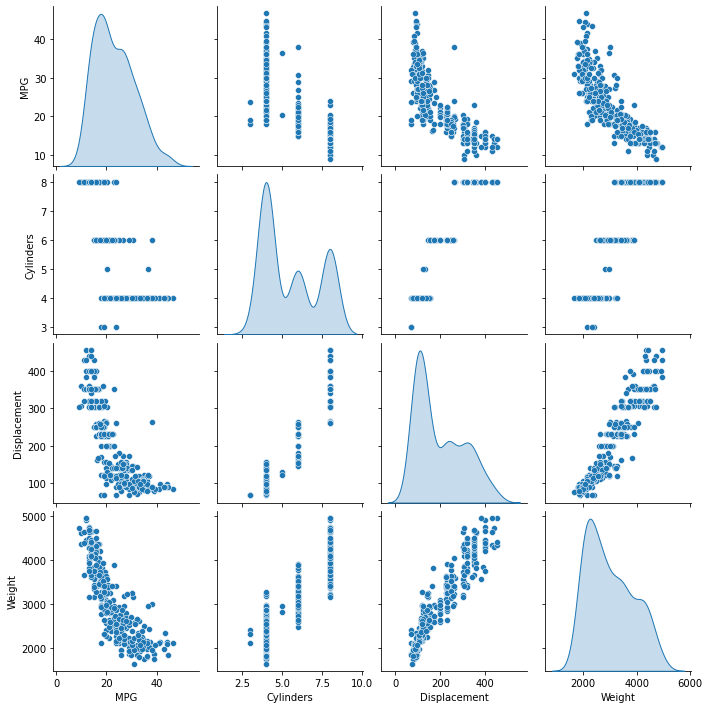

In [8]:
sns.pairplot(train_df[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

## Split Features and labels

In [9]:
# training 
X_train = train_df.drop(columns=['MPG']).copy()
y_train = train_df['MPG'].copy()
# testing
X_test = test_df.drop(columns=['MPG']).copy()
y_test = test_df['MPG'].copy()

In [10]:
print('Shape of Training Features',X_train.shape)
print('Shape of Training labels',y_train.shape)
print('Shape of Training Features',X_test.shape)
print('Shape of Training labels',y_test.shape)

Shape of Training Features (314, 9)
Shape of Training labels (314,)
Shape of Training Features (78, 9)
Shape of Training labels (78,)


## Normalization
In the table of statistics it's easy to see how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.

**Note: There is no advantage to normalizing the one-hot features**

In [11]:
train_df.describe().T[['mean', 'std']]

,mean,std
MPG,23.153822,7.861854
Cylinders,5.531847,1.729449
Displacement,197.855096,106.501896
Horsepower,105.971338,39.636557
Weight,3005.745223,859.060925
Acceleration,15.510828,2.803560
Model Year,75.910828,3.688989
Europe,0.171975,0.377961
Japan,0.203822,0.403481
USA,0.624204,0.485101


`tf.keras.layers.experimental.preprocessing.Normalization`
This layer will coerce its inputs into a distribution centered around
0 with standard deviation 1. It accomplishes this by precomputing the mean and
variance of the data, and calling (input-mean)/sqrt(var) at runtime.

What happens in adapt: Compute mean and variance of the data and store them
  as the layer's weights. adapt should be called before fit, evaluate,
or predict.

In [12]:
normalizer = tf.keras.layers.experimental.preprocessing.Normalization()

In [13]:
normalizer.adapt(X_train)

In [14]:
print('Mean computed from training data',normalizer.mean.numpy())

Mean computed from training data [5.53184700e+00 1.97855103e+02 1.05971344e+02 3.00574561e+03
 1.55108280e+01 7.59108276e+01 1.71974540e-01 2.03821689e-01
 6.24203801e-01]


In [15]:
# eg normalization
first_row = X_train[:1]
print('ROW before normalization \n', first_row.values)
print('ROW after normalization \n', normalizer(first_row).numpy())

ROW before normalization 
 [[4.000e+00 9.600e+01 6.900e+01 2.189e+03 1.800e+01 7.200e+01 1.000e+00
  0.000e+00 0.000e+00]]
ROW after normalization 
 [[-0.8871564  -0.95789564 -0.9342477  -0.9522599   0.8892784  -1.0618277
   2.1942682  -0.5059645  -1.2888044 ]]


## Linear Regression

Before building a DNN model, start with a linear regression.

### Single Variable
Start with a single-variable linear regression, to predict MPG from Horsepower.

Training a model with `tf.keras` typically starts by defining the model architecture.

In this case use a ` keras.Sequential model`. This model represents a sequence of steps. In this case there are two steps:

* Normalize the input horsepower.
* Apply a linear transformation () to produce 1 output using `layers.Dense`.



In [16]:
horse_power = np.array(X_train['Horsepower'])

In [17]:
horse_power_normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
horse_power_normalizer.adapt(horse_power)

#### Model

In [18]:
horse_power_model = tf.keras.Sequential([
                                         horse_power_normalizer,
                                         tf.keras.layers.Dense(1)
])

In [19]:
horse_power_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


#### Compile the model

In [20]:
horse_power_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                          loss = 'mae',
                          metrics=['mae'])

#### Early stopping callback

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#### Training

In [22]:
horse_power_history = horse_power_model.fit(X_train['Horsepower'], y_train, validation_split=0.2, epochs=100, callbacks=[early_stopping])

Epoch 1/100
8/8 [==============================] - 1s 30ms/step - loss: 23.0929 - mae: 23.0929 - val_loss: 21.3014 - val_mae: 21.3014
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 22.2714 - mae: 22.2714 - val_loss: 20.5272 - val_mae: 20.5272
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 21.4669 - mae: 21.4669 - val_loss: 19.7459 - val_mae: 19.7459
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 20.6588 - mae: 20.6588 - val_loss: 18.9708 - val_mae: 18.9708
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 19.8571 - mae: 19.8571 - val_loss: 18.2028 - val_mae: 18.2028
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 19.0463 - mae: 19.0463 - val_loss: 17.4269 - val_mae: 17.4269
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 18.2406 - mae: 18.2406 - val_loss: 16.6558 - val_mae: 16.6558
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - los

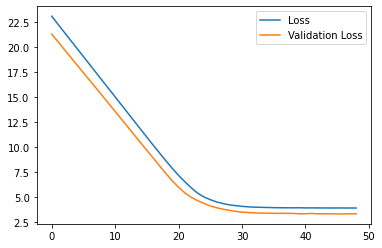

In [23]:
plt.plot(horse_power_history.epoch, horse_power_history.history['loss'], label='Loss')
plt.plot(horse_power_history.epoch, horse_power_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

#### Evaluation

In [24]:
# evalaution
loss, mae = horse_power_model.evaluate(X_test['Horsepower'], y_test)
print('Loss',loss)
print('MAE',mae)

3/3 [==============================] - 0s 5ms/step - loss: 3.9574 - mae: 3.9574
Loss 3.9573755264282227
MAE 3.9573755264282227


#### Plots

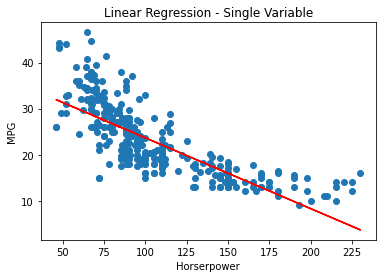

In [25]:
plt.scatter(X_train['Horsepower'], y_train);
plt.plot(X_train['Horsepower'], horse_power_model.predict(X_train['Horsepower']), color='red');
plt.xlabel('Horserpower')
plt.ylabel('MPG')
plt.title('Linear Regression - Single Variable')
plt.show()

### Multiple Variable
You can use an almost identical setup to make predictions based on multiple inputs. 

#### Model building and training

In [26]:
multi_var_reg_model = tf.keras.Sequential([
                                           normalizer,
                                           tf.keras.layers.Dense(1)
])

# compile the model
multi_var_reg_model.compile(optimizer=tf.keras.optimizers.Adam(0.1),
                            loss='mae',
                            metrics=['mae'])

# training
multi_var_history = multi_var_reg_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
8/8 [==============================] - 1s 26ms/step - loss: 23.0933 - mae: 23.0933 - val_loss: 21.7328 - val_mae: 21.7328
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 22.1623 - mae: 22.1623 - val_loss: 21.0585 - val_mae: 21.0585
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 21.3270 - mae: 21.3270 - val_loss: 20.4859 - val_mae: 20.4859
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 20.4625 - mae: 20.4625 - val_loss: 19.9101 - val_mae: 19.9101
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 19.6055 - mae: 19.6055 - val_loss: 19.3352 - val_mae: 19.3352
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 18.7461 - mae: 18.7461 - val_loss: 18.7774 - val_mae: 18.7774
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 17.9050 - mae: 17.9050 - val_loss: 18.2584 - val_mae: 18.2584
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - los

#### Model Evaluation

In [27]:
loss, mae = multi_var_reg_model.evaluate(X_test, y_test)
print('Loss',loss)
print('MAE',mae)

3/3 [==============================] - 0s 4ms/step - loss: 2.5969 - mae: 2.5969
Loss 2.5968878269195557
MAE 2.5968878269195557


#### Plots

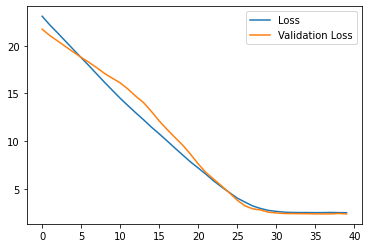

In [28]:
plt.plot(multi_var_history.epoch, multi_var_history.history['loss'], label='Loss')
plt.plot(multi_var_history.epoch, multi_var_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


## A DNN regression
The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer.
* Two hidden, nonlinear, Dense layers using the relu nonlinearity.
* A linear single-output layer.

Both will use the same training procedure so the compile method is included in the build_and_compile_model function below.


### Single Variable

Model architecture:

* The normalization layer.
* Two hidden, nonlinear, Dense layers using the relu nonlinearity.
* A linear single-output layer.

#### Model building and training

In [29]:
dnn_horse_power_model = tf.keras.Sequential([
                                             horse_power_normalizer,
                                             tf.keras.layers.Dense(64, activation='relu'),
                                             tf.keras.layers.Dense(64, activation='relu'),
                                             tf.keras.layers.Dense(1)
])

# compile
dnn_horse_power_model.compile(optimizer='adam', loss='mae', metrics=['mae'])

# training
dnn_horse_power_history = dnn_horse_power_model.fit(X_train['Horsepower'], y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
8/8 [==============================] - 1s 33ms/step - loss: 23.2827 - mae: 23.2827 - val_loss: 21.8583 - val_mae: 21.8583
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 23.0442 - mae: 23.0442 - val_loss: 21.6063 - val_mae: 21.6063
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 22.7799 - mae: 22.7799 - val_loss: 21.3180 - val_mae: 21.3180
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 22.4670 - mae: 22.4670 - val_loss: 20.9487 - val_mae: 20.9487
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 22.0543 - mae: 22.0543 - val_loss: 20.4527 - val_mae: 20.4527
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 21.5008 - mae: 21.5008 - val_loss: 19.7815 - val_mae: 19.7815
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 20.7538 - mae: 20.7538 - val_loss: 18.9199 - val_mae: 18.9199
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - los

#### Model Evaluation

In [30]:
loss, mae = dnn_horse_power_model.evaluate(X_test['Horsepower'], y_test)
print('Loss',loss)
print('MAE',mae)

3/3 [==============================] - 0s 3ms/step - loss: 3.5341 - mae: 3.5341
Loss 3.5340569019317627
MAE 3.5340569019317627


#### Plots

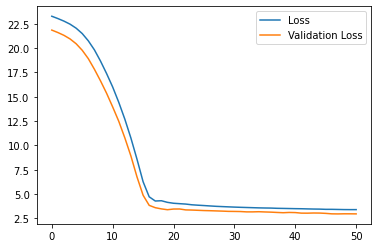

In [31]:
plt.plot(dnn_horse_power_history.epoch, dnn_horse_power_history.history['loss'], label='Loss')
plt.plot(dnn_horse_power_history.epoch, dnn_horse_power_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

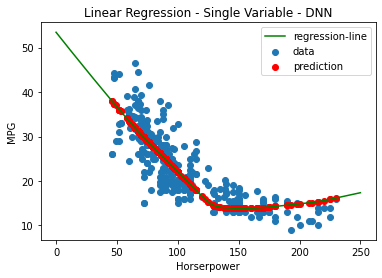

In [42]:
x = np.linspace(0,250,251)
y = dnn_horse_power_model.predict(x)

plt.scatter(X_train['Horsepower'], y_train, label='data');
plt.plot(x, y, color='green', label='regression-line')
plt.scatter(X_train['Horsepower'], dnn_horse_power_model.predict(X_train['Horsepower']), color='red', label='prediction')
plt.xlabel('Horserpower')
plt.ylabel('MPG')
plt.title('Linear Regression - Single Variable - DNN')
plt.legend()
plt.show()

### Multi Variable


#### Model building and Training

In [50]:
# model
dnn_model = tf.keras.Sequential([
                                 normalizer,
                                 tf.keras.layers.Dense(64, activation='relu'),
                                 tf.keras.layers.Dense(64, activation='relu'),
                                 tf.keras.layers.Dense(1),
])

# compile and train
dnn_model.compile(optimizer='adam', loss='mae', metrics=['mae'])

# train
dnn_history = dnn_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
8/8 [==============================] - 1s 42ms/step - loss: 22.5823 - mae: 22.5823 - val_loss: 21.0051 - val_mae: 21.0051
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 21.7877 - mae: 21.7877 - val_loss: 20.1606 - val_mae: 20.1606
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 20.8502 - mae: 20.8502 - val_loss: 19.1434 - val_mae: 19.1434
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 19.6730 - mae: 19.6730 - val_loss: 17.8158 - val_mae: 17.8158
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 18.1218 - mae: 18.1218 - val_loss: 16.0555 - val_mae: 16.0555
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 16.0281 - mae: 16.0281 - val_loss: 13.8310 - val_mae: 13.8310
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 13.5849 - mae: 13.5849 - val_loss: 11.5776 - val_mae: 11.5776
Epoch 8/100
8/8 [==============================] - 0s 8ms/step - los

#### Model Evaluation

In [52]:
loss, mae = dnn_model.evaluate(X_test, y_test)
print('Loss',loss)
print('MAE',mae)

3/3 [==============================] - 0s 5ms/step - loss: 2.1120 - mae: 2.1120
Loss 2.111959934234619
MAE 2.111959934234619


#### Plots

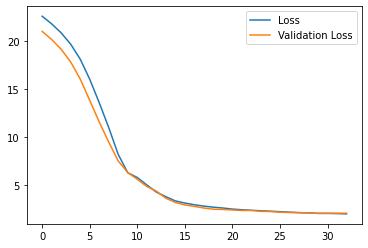

In [53]:
plt.plot(dnn_history.epoch, dnn_history.history['loss'], label='Loss')
plt.plot(dnn_history.epoch, dnn_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()